# Machine Learning Modeling

Experimented using 3 models:

* Time Series Forcasting - Prophet Model
* Linear Regression
* Random Forest Regressor

First, load the data and compute the features to be used in model training ...

In [1]:
import pandas as pd 

# load clean dataset
cleaned_df = pd.read_csv('../data/cleaned_solar_irradiation.csv', index_col=0)
cleaned_df = cleaned_df[pd.to_datetime(cleaned_df.index) > pd.to_datetime("2018-01-01", format='%Y-%m-%d')]
cleaned_df.columns

Index(['MonthPE', 'Date', 'Daily_Temp', 'Daily_Precip', 'Daily_Humidity',
       'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed', 'Daily_DNI',
       'Daily_DHI', 'Daily_radiation'],
      dtype='object')

In [2]:
# Feature Engineering of Time Series Column
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'], format='%Y-%m-%d')
cleaned_df['year'] = cleaned_df['Date'].dt.year
cleaned_df['month'] = cleaned_df['Date'].dt.month
cleaned_df['day'] = cleaned_df['Date'].dt.day

# select features
cleaned_df = cleaned_df[['month', 'day', 'Daily_Temp', 'Daily_Precip', 'Daily_Humidity',
       'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed', 'Daily_DNI',
       'Daily_DHI', 'Daily_radiation']]

cleaned_df.head()

,month,day,Daily_Temp,Daily_Precip,Daily_Humidity,Daily_Pressure,Daily_WindDir,Daily_WindSpeed,Daily_DNI,Daily_DHI,Daily_radiation
2018-01-02,1,2,15.518182,12.763636,50.363636,1004.963636,253.363636,3.345455,558.545455,80.090909,334.454545
2018-01-03,1,3,15.600000,12.430000,49.300000,1003.010000,228.400000,4.150000,144.000000,170.600000,235.700000
2018-01-04,1,4,15.727273,13.572727,48.636364,999.263636,246.818182,6.554545,449.636364,112.000000,327.727273
2018-01-05,1,5,16.440000,14.830000,57.900000,996.770000,275.300000,9.330000,0.400000,86.000000,86.100000
2018-01-06,1,6,15.981818,12.890909,58.181818,1003.990909,304.818182,3.363636,434.545455,115.181818,298.636364


## Model Training

Let's have a second look on the original data we have for the daily radiation (in Cairo, Egypt) ...

<AxesSubplot:xlabel='Date', ylabel='Daily Radiation'>

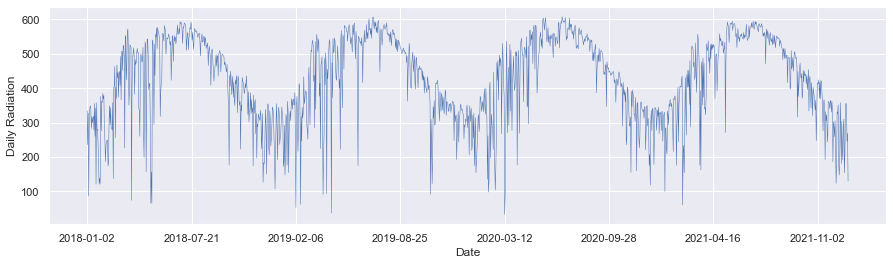

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 4)})

plt.ylabel('Daily Radiation')
plt.xlabel('Date')
plt.xticks(rotation=45)

cleaned_df['Daily_radiation'].plot(linewidth=0.5)

#### Split data into training, validation & test subsets ...
(by dividing the time series into intervals)

In [4]:
training_data = cleaned_df[pd.to_datetime(cleaned_df.index) < pd.to_datetime("2021-01-01", format='%Y-%m-%d')]
validation_data = cleaned_df[(pd.to_datetime(cleaned_df.index) >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')) & (
    pd.to_datetime(cleaned_df.index) < pd.to_datetime("2021-07-01", format='%Y-%m-%d'))]
test_data = cleaned_df[pd.to_datetime(cleaned_df.index) > pd.to_datetime("2021-07-01", format='%Y-%m-%d')]

# convert dataframes to .csv and save locally
training_data.to_csv('../data/train.csv', header = True, index = False)
validation_data.to_csv('../data/validation.csv', header=True, index = False)
test_data.to_csv('../data/test.csv', header = True, index = False)

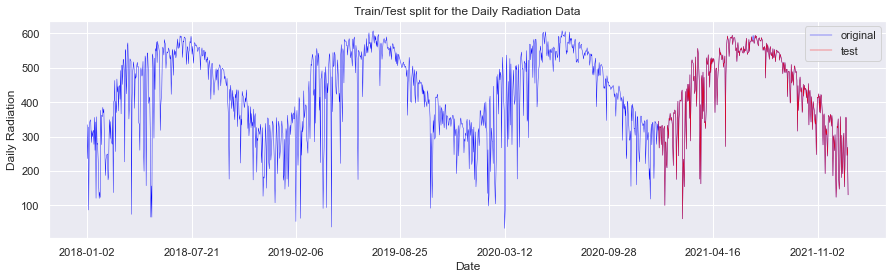

In [5]:
# add type just to help with the visualization step 
original = cleaned_df.copy() 
original['type'] = 'original'

valid = validation_data.copy()
valid['type'] = 'validation'

test = test_data.copy()
test['type'] = 'test'

# plot splitted time series
sns.set(rc={'figure.figsize':(15, 4)})

pd.concat([original[['Daily_radiation', 'type']], valid[['Daily_radiation', 'type']], test[['Daily_radiation', 'type']]], axis=1).plot(
    label='type', color=['blue', 'red', 'red'], linewidth=0.4)

plt.ylabel('Daily Radiation')
plt.xlabel('Date')
plt.title("Train/Test split for the Daily Radiation Data")
plt.legend(['original', 'test'], loc='best')

### [Model-1] Linear Regression

In [6]:
# training data
X_train = training_data.drop(['Daily_radiation'], axis = 1)
y_train = training_data['Daily_radiation']

# validation data
X_valid = validation_data.drop(['Daily_radiation'], axis = 1)
y_valid = validation_data['Daily_radiation']

# test data
X_test = test_data.drop(['Daily_radiation'], axis = 1)
y_test = test_data['Daily_radiation']

In [7]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Setup the pipeline for linear regression
steps = [('scaler', StandardScaler()), ('lr', LinearRegression())]
pipeline_lr = Pipeline(steps)

# Fit on training set
pipeline_lr.fit(X_train, y_train)
# Predict test set
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluating algorithm performance
mse = mean_squared_error(y_test, y_pred_lr, squared = False)
mae = mean_absolute_error(y_test, y_pred_lr)
print('r2_score: ', r2_score(y_test, y_pred_lr))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae))

r2_score:  0.9564307194333266
Root Mean Squared Error: 4.94
Root Mean Absolute Error: 4.26


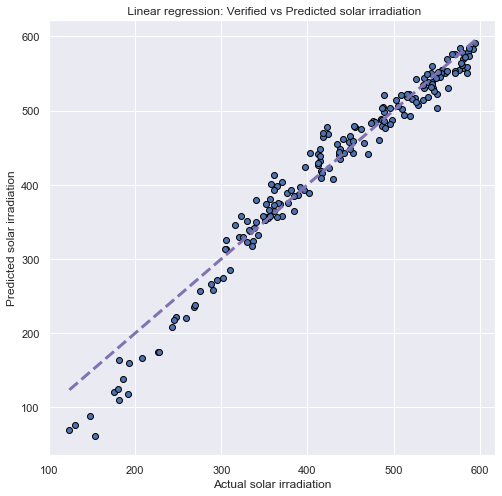

In [8]:
# Run the model against the test data presented through a plot
fig, pX = plt.subplots(figsize =(8,8))

pX.scatter(y_test, y_pred_lr, edgecolors = (0, 0, 0))
pX.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw = 3)
pX.set_xlabel('Actual solar irradiation')
pX.set_ylabel('Predicted solar irradiation')
pX.set_title(" Linear regression: Verified vs Predicted solar irradiation")
plt.show() 

C:\Users\CIT-USER\anaconda3\envs\dsEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


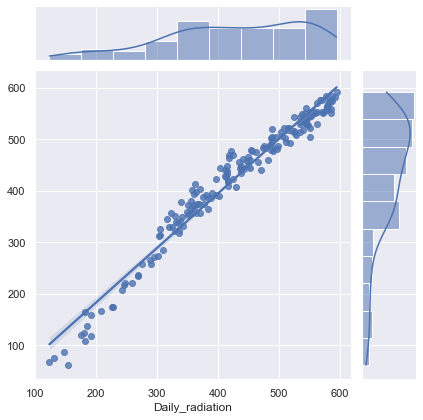

In [9]:
sns.jointplot(y_test, y_pred_lr, kind = 'reg')
plt.show()

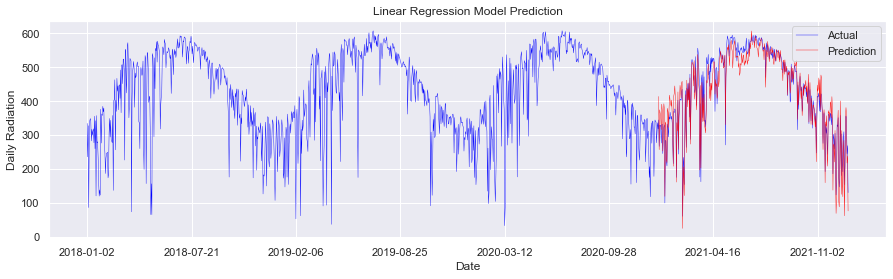

In [16]:
to_plot = cleaned_df.copy() 
to_plot['type'] = 'original'

pred_df = pd.concat([
    pd.DataFrame(y_pred_lr, columns=['Daily_radiation'], index=test_data.index),
    pd.DataFrame(pipeline_lr.predict(X_valid), columns=['Daily_radiation'], index=validation_data.index)])

pred_df['type'] = 'prediction'

# plot splitted time series
sns.set(rc={'figure.figsize':(15, 4)})

pd.concat([to_plot[['Daily_radiation', 'type']], pred_df[['Daily_radiation', 'type']]], axis=1).plot(
    label='type', color=['blue', 'red'], linewidth=0.4)

plt.ylabel('Daily Radiation')
plt.xlabel('Date')
plt.title("Linear Regression Model Prediction")
plt.legend(['Actual', 'Prediction'], loc='best')

### [Model-2] Prophet Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


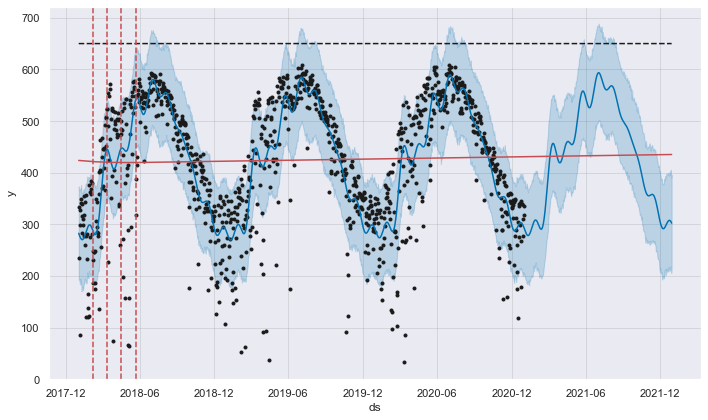

In [11]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

ts_df = training_data[['Daily_radiation']].reset_index(drop=False)
ts_df.columns = ['ds', 'y']
ts_df['cap'] = 650

m = Prophet(growth='logistic', weekly_seasonality=False)
m.fit(ts_df)

future = m.make_future_dataframe(periods=(validation_data.shape[0]+test_data.shape[0]))
future['cap'] = 650
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [14]:
# Evaluate model performance
mse_p = mean_squared_error(y_test, forecast['yhat'][-182:].values, squared = False)
mae_p = mean_absolute_error(y_test, forecast['yhat'][-182:].values)
print('r2_score: ', r2_score(y_test, forecast['yhat'][-182:].values))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_p))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_p))

r2_score:  0.822211036639994
Root Mean Squared Error: 7.02
Root Mean Absolute Error: 5.72


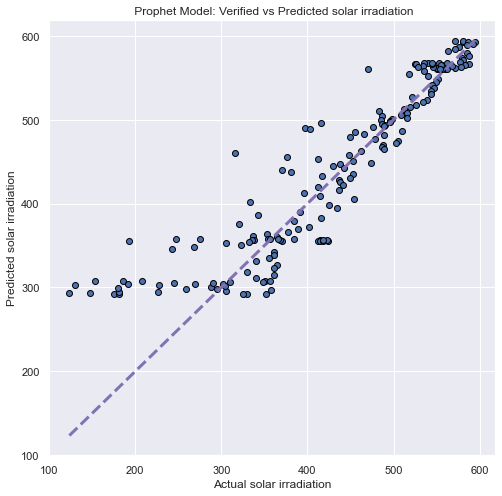

In [18]:
fig, pX = plt.subplots(figsize =(8,8))

pX.scatter(y_test, forecast['yhat'][-182:].values, edgecolors = (0, 0, 0))
pX.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw = 3)
pX.set_xlabel('Actual solar irradiation')
pX.set_ylabel('Predicted solar irradiation')
pX.set_title(" Prophet Model: Verified vs Predicted solar irradiation")
plt.show() 

C:\Users\CIT-USER\anaconda3\envs\dsEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


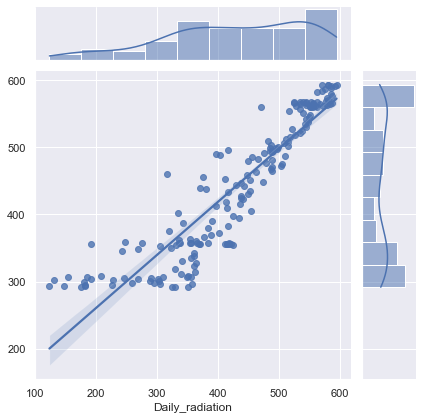

In [20]:
sns.jointplot(y_test, forecast['yhat'][-182:].values, kind = 'reg')
plt.show()

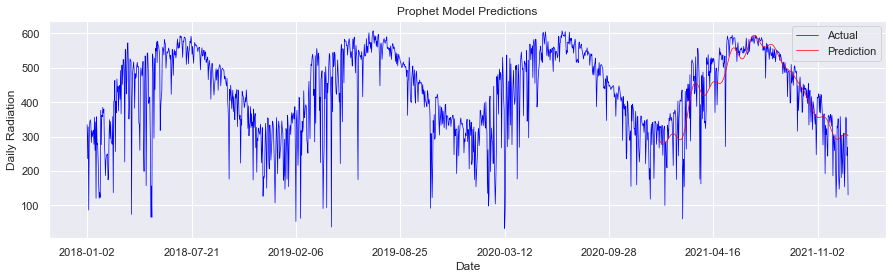

In [21]:
to_plot = cleaned_df.copy() 
to_plot['type'] = 'original'

pred_df = pd.concat([validation_data[['Daily_radiation']], test_data[['Daily_radiation']]])
pred_df['Daily_radiation'] = forecast['yhat'][-363:].values
pred_df['type'] = 'prediction'

# plot splitted time series
sns.set(rc={'figure.figsize':(15, 4)})

pd.concat([to_plot[['Daily_radiation', 'type']], pred_df[['Daily_radiation', 'type']]], axis=1).plot(
    label='type', color=['blue', 'red'], linewidth=0.7)

plt.ylabel('Daily Radiation')
plt.xlabel('Date')
plt.title("Prophet Model Predictions")
plt.legend(['Actual', 'Prediction'], loc='best')

### [Model-2] Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Setup the pipeline for random forest
steps = [('scaler', StandardScaler()), ('rfr', RandomForestRegressor())]
pipeline_rfr = Pipeline(steps)

pipeline_rfr.fit(X_train, y_train)
y_pred_rfr = pipeline_rfr.predict(X_test)
y_pred_rfr_v = pipeline_rfr.predict(X_valid)

# Evaluating algorithm performance
mse_rf = mean_squared_error(y_test, y_pred_rfr, squared = False)
mae_rf = mean_absolute_error(y_test, y_pred_rfr)
print('r2_score: ', r2_score(y_test, y_pred_rfr))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_rf))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_rf))

r2_score:  0.9830765856914279
Root Mean Squared Error: 3.90
Root Mean Absolute Error: 3.27


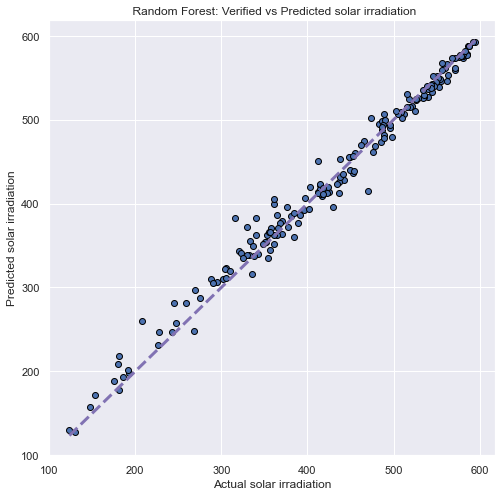

In [23]:
# Run the model against the test data presented through a plot
fig, pX = plt.subplots(figsize =(8,8))

pX.scatter(y_test, y_pred_rfr, edgecolors = (0, 0, 0))
pX.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw = 3)
pX.set_xlabel('Actual solar irradiation')
pX.set_ylabel('Predicted solar irradiation')
pX.set_title(" Random Forest: Verified vs Predicted solar irradiation")
plt.show()

C:\Users\CIT-USER\anaconda3\envs\dsEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


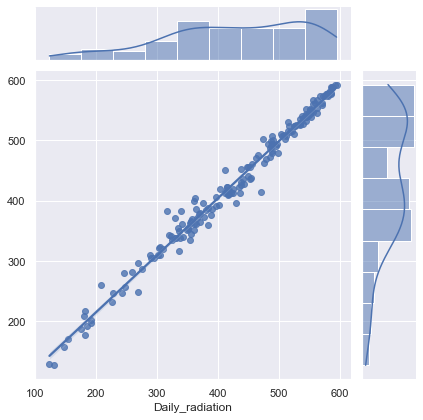

In [24]:
sns.jointplot(y_test, y_pred_rfr, kind = 'reg')
plt.show()

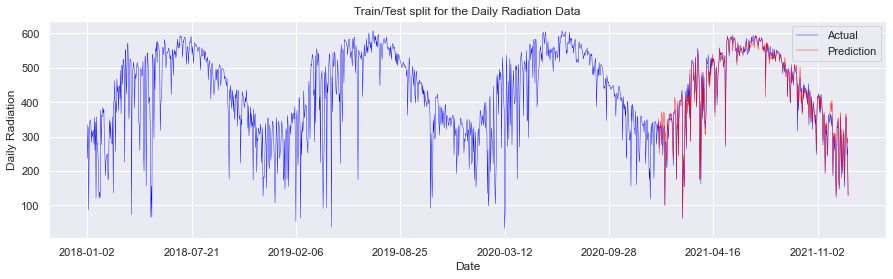

In [25]:
to_plot = cleaned_df.copy() 
to_plot['type'] = 'original'

pred_df = pd.concat([
    pd.DataFrame(y_pred_rfr, columns=['Daily_radiation'], index=test_data.index),
    pd.DataFrame(y_pred_rfr_v, columns=['Daily_radiation'], index=validation_data.index)])

pred_df['type'] = 'prediction'

# plot splitted time series
sns.set(rc={'figure.figsize':(15, 4)})

pd.concat([to_plot[['Daily_radiation', 'type']], pred_df[['Daily_radiation', 'type']]], axis=1).plot(
    label='type', color=['blue', 'red'], linewidth=0.4)

plt.ylabel('Daily Radiation')
plt.xlabel('Date')
plt.title("Train/Test split for the Daily Radiation Data")
plt.legend(['Actual', 'Prediction'], loc='best')

## Conclusion

Models Performance:

| Model | r2_score | RMSE | RMAE |
| --- | --- | --- | --- |
| Linear Regression | 0.96 | 4.94 | 4.26 |
| Prophet Model | 0.82 | 7.02 | 5.72 |
| Random Forest Regressor | 0.98 | 3.90 | 3.27 |


As we can conclude from the performance table, Random Forest Regressor acheived the best performance (lowest error values).